# Projet Deep Learning :

Par Nathan Saincourt et Flavian Ferré

---

### Objectif :

Dans ce projet, nous allons construire un modèle de réseau de neurones afin de pouvoir prédire le sentiment (positif ou négatif) de critiques cinématographiques. Ce projet présente quelques difficultés car les critiques peuvent être ironiques, trompeuses ou peu précises. Nous allons donc tenter plusieurs techniques de préprocessing afin de préparer au mieux les données afin de classifier au mieux nos critiques.

---

# Importations

In [1]:
%pip install stop_words
%pip install en_core_web_sm

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import spacy
import stop_words
import tensorflow as tf

from tensorflow import keras

from keras import Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import BatchNormalization, Dense, Dropout, Input, TextVectorization
from keras.metrics import F1Score
from keras.optimizers import Adadelta, Adam, RMSprop
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

# Data à importer

Pour réaliser ce projet, nous nous basons sur la base de données mises à disposition par IMDB contenant des critiques cinématographiques et leur sentiment global (50000 critiques).

Voir le lien ici pour plus de détails : https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews/data

In [2]:
df_train = pd.read_csv('../data/IMDB_dataset.csv')

# Import des stop-words en anglais pour traiter les textes
stop_words_en = stop_words.get_stop_words('en')

# Train / Test split

Cette étape nous permet de séparer nos données d'entraînement et de test ainsi que de séparer nos cibles des textes contenant les critiques cinématographiques.

**Cette étape ne doit être réalisée que si les fichiers ne sont pas déjà présents.**

In [6]:
# Division en train/test
X = df_train['review']
y = df_train['sentiment'].map({'positive': 1, 'negative': 0})
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.to_csv('../data/X_train.csv')
X_test.to_csv('../data/X_test.csv')
y_train.to_csv('../data/y_train.csv')
y_test.to_csv('../data/y_test.csv')

# Lemmatisation

Cette étape nous permet de nettoyer un texte pour l'analyse. Elle transforme les mots en leur forme de base (c'est le principe de lemmatisation, par exemple "courir" sera utilisé à la place de "courant") et supprime tout ce qui n’est pas alphabétique (comme les chiffres ou la ponctuation). Le résultat est une version simplifiée et standardisée du texte, prête pour des tâches de traitement du langage naturel et s'avère être plus performante pour notre modèle que si nous ne l'utilisions pas (voir détails plus tard), car elle prend mieux en compte l'ironie ou d'autres éléments de langage trompeur en gardant une syntaxe identique pour toute critique positive ou négative.

**Cette étape ne doit être réalisée que si les fichiers ne sont pas déjà présents car elle est très longue à réaliser (1h environ).**

In [ ]:
nlp = spacy.load('en_core_web_sm')

# Lemmatisation du texte
def preprocess_text(text):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc if token.is_alpha])

X_train_processed = X_train.apply(preprocess_text)
X_test_processed = X_test.apply(preprocess_text)

In [8]:
X_train_processed.to_csv('../data/X_train_processed.csv')
X_test_processed.to_csv('../data/X_test_processed.csv')

# Notre modèle Keras

In [4]:
# Lecture des CSV créés
X_train = pd.read_csv('../data/X_train.csv', index_col=0)['review']
X_test = pd.read_csv('../data/X_test.csv', index_col=0)['review']
y_train = pd.read_csv('../data/y_train.csv', index_col=0)['sentiment']
y_test = pd.read_csv('../data/y_test.csv', index_col=0)['sentiment']
X_train_processed = pd.read_csv('../data/X_train_processed.csv', index_col=0)['review']
X_test_processed = pd.read_csv('../data/X_test_processed.csv', index_col=0)['review']

In [5]:
# Conversions pour pouvoir appliquer au modèle
X_train_list = X_train_processed.tolist()
X_test_list = X_test_processed.tolist()

X_train_tf = tf.constant(X_train_list)
X_test_tf = tf.constant(X_test_list)

Dans la prochaine fonction, nous créons un modèle défini pour un optimisateur et des paramètres particuliers, donnés en entrée. **L'optimisateur permet d'accélerer le modèle et de le rendre plus précis**, comme nous avons pu le voir en cours.

Nous avons aussi ajouté un **vectorizer** qui nous permet de transformer le texte en entrée pour pouvoir l'appliquer au modèle (sinon il ne pouvait être traité par le réseau de neurones). Nous avons choisi le mode 'TF-IDF' car il se révèle être le plus efficace pour **traiter de longs textes** comme nos critiques.

Enfin, la **structure du modèle choisi** est la suivante :
- Une couche d'entrée pour recevoir les données sous forme de texte
- Un Vectorizer pour pouvoir traiter les données d'entrée dans les prochaines couches
- Une couche de Batch Normalization pour accélérer l'apprentissage (car nous avons un grand nombre de données d'entraînement)
- Une couche Dense (avec activation ReLU et régularisation L2)
- Une couche Dropout pour éviter le sur-apprentissage
- Une couche Dense de sortie (avec activation Sigmoid et régularisation L2 comme il est coutume de faire)

Ce fut la structure la plus efficace, si l'on regarde **le F1-Score d'entraînement, métrique prenant en compte à la fois le rappel et la précision**. En effet, nous avons testé les combinaisons suivantes, ayant donné un F1-Score inférieur à celui de la structure précédente (les chouches décrites seront celles entre la BatchNormalization et la Dense de sortie) :
- **Notre structure actuelle : 0.899033**
- 1 Dense sans Dropout (avec Lemmatisation) : 0.898453
- 2 Dense avec une Dropout (avec Lemmatisation) : 0.883923
- 2 Dense sans Dropout (avec Lemmatisation) : 0.880723
- 1 Dense sans Dropout (sans Lemmatisation) : 0.873163
- 2 Dense sans Dropout (sans Lemmatisation) : 0.869383
- 3 Dense avec 2 Dropout (avec Lemmatisation) : 0.853393

Donc, augmenter le nombre de couches Dense, supprimer la Lemmatisation et supprimer les couches Dropout revenaient à diminuer le F1-Score. Le meilleur modèle est donc le plus simple.

In [6]:
# Fonction pour créer le modèle correspondant aux paramètres d'entrée
def create_model(optimizer='adam', dense_length=64, learning_rate=0.001, rho=0.95, epsilon=1e-07, momentum=0.0, threshold=0.5, max_tokens=10000, dropout_rate=0.5):
    
    # Choix de l'optimisateur et de ses paramètres
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate, epsilon=epsilon)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate, rho=rho, epsilon=epsilon, momentum=momentum)
    elif optimizer == 'adadelta':
        opt = Adadelta(learning_rate=learning_rate, rho=rho, epsilon=epsilon)

    # Vectorisateur du texte
    vectorizer = TextVectorization(output_mode='tf-idf', max_tokens=max_tokens)
    vectorizer.adapt(X_train_list)

    # Structure du modèle le plus efficace
    model = Sequential([
        Input(shape=(1,), dtype=tf.string),
        vectorizer,
        BatchNormalization(),
        Dense(dense_length, activation='relu', kernel_regularizer='l2'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid', kernel_regularizer='l2')
    ])

    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[F1Score(threshold=threshold)])

    return model

In [7]:
# Paramètres à tester pour chaque optimisateur
param_dist_adam = {
    'optimizer': ['adam'],
    'dense_length': [16, 32, 64, 128, 256, 512],
    'learning_rate': [0.1, 0.01, 0.005, 0.001, 0.0005, 0.0001],
    'threshold': [0.4, 0.42, 0.45, 0.5],
    'dropout_rate': [0.3, 0.4, 0.5, 0.6],
    'max_tokens': [5000, 10000, 20000]
}
param_dist_rmsprop = {
    'optimizer': ['rmsprop'],
    'dense_length': [16, 32, 64, 128, 256, 512],
    'learning_rate': [0.1, 0.01, 0.005, 0.001, 0.0005, 0.0001],
    'rho': [0.85, 0.9, 0.95],
    'epsilon': [1e-08, 1e-07, 1e-06],
    'momentum': [0.0, 0.2, 0.5],
    'threshold': [0.4, 0.42, 0.45, 0.5],
    'dropout_rate': [0.3, 0.4, 0.5, 0.6],
    'max_tokens': [5000, 10000, 20000]
}
param_dist_adadelta = {
    'optimizer': ['adadelta'],
    'dense_length': [16, 32, 64, 128, 256, 512],
    'learning_rate': [0.1, 0.01, 0.005, 0.001, 0.0005, 0.0001],
    'rho': [0.85, 0.9, 0.95],
    'epsilon': [1e-08, 1e-07, 1e-06],
    'threshold': [0.4, 0.42, 0.45, 0.5],
    'dropout_rate': [0.3, 0.4, 0.5, 0.6],
    'max_tokens': [5000, 10000, 20000]
}
param_grid = [
    param_dist_adam,
    param_dist_rmsprop,
    param_dist_adadelta
]

Une fois les différents paramètres à tester choisis, nous avons créé une fonction de grid_search pour pouvoir tester aléatoirement 30 combinaisons de paramètres pour chaque optimiseur, afin de trouver la combinaison la plus efficace. Nous avons recréé ce grid search nous-mêmes pour qu'il prenne en compte la fonction create_model précédente et qu'il intègre deux méthodes de régularisation (pour éviter le sur-apprentissage):

- **Early Stopping** : stoppe le modèle avant que l'erreur du modèle ne réaugmente pour conserver un bon compromis erreur-F1Score
- **ReduceLROnPlateau** : réduit le Learning Rate de l'optimisateur lorsque l'erreur commence à stagner pour redynamiser le modèle et diminuer au maximum l'erreur.

In [8]:
# Grid search pour trouver les meilleurs paramètres
def grid_search(X_train, y_train, X_val, y_val, param_grid, n_iter):
    best_score = -1
    best_params = None
    
    for param_dist in param_grid: # Pour chaque optimisateur
        for _ in range(n_iter):
            params = {key: random.choice(value) for key, value in param_dist.items()}
            print(f"Testing parameters: {params}")

            model = create_model(**params)

            # Méthodes de régularisation pour améliorer le modèle et éviter l'overfitting
            early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
            reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.000001)
            callbacks_list = [early_stopping, reduce_lr]
            
            model.fit(
                X_train, y_train, 
                epochs=20, 
                batch_size=128, 
                validation_data=(X_val, y_val), 
                callbacks=callbacks_list
            )
            
            # Prédictions
            val_predictions = model.predict(X_val)
            val_predictions_cat = np.where(val_predictions>0.4,1,0)
            val_predictions_series = pd.Series(val_predictions_cat.flatten(), index=y_val.index)

            val_f1 = f1_score(y_val, val_predictions_series)
            print(f"F1-Score : {val_f1}")
            
            # Si on a le meilleur score
            if val_f1 > best_score:
                best_score = val_f1
                best_params = params
        
            model = None
            
    return best_score, best_params

best_score, best_params = grid_search(X_train_tf, y_train, X_test_tf, y_test, param_grid, n_iter=30)

print("Best F1-Score: %f using %s" % (best_score, best_params))

Testing parameters: {'optimizer': 'adam', 'dense_length': 32, 'learning_rate': 0.005, 'threshold': 0.45, 'dropout_rate': 0.5, 'max_tokens': 5000}
Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - f1_score: 0.8043 - loss: 1.0172 - val_f1_score: 0.8660 - val_loss: 0.8023 - learning_rate: 0.0050
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - f1_score: 0.8514 - loss: 0.8253 - val_f1_score: 0.8603 - val_loss: 0.7721 - learning_rate: 0.0050
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - f1_score: 0.8572 - loss: 0.7878 - val_f1_score: 0.8646 - val_loss: 0.7418 - learning_rate: 0.0050
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - f1_score: 0.8585 - loss: 0.7635 - val_f1_score: 0.8697 - val_loss: 0.7211 - learning_rate: 0.0050
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - f1_score: 0.8541 - loss: 0.7435 - val_f1_score: 0.8685 - val_loss: 0.7321 - learning_rate: 0.0050
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - f1_score: 0.8606 - loss: 0.7356 - 

Une fois notre combinaison idéale trouvée, nous l'appliquons une dernière fois à notre modèle complet (structure + régularisateurs) pour pouvoir réaliser nos "vraies" prédictions.

In [9]:
# Vectorisateur du texte
vectorizer = TextVectorization(output_mode='tf-idf', max_tokens=best_params['max_tokens'])
vectorizer.adapt(X_train_list)

# Structure du modèle choisi (celui qui est optimal)
model = Sequential([
    Input(shape=(1,), dtype=tf.string),
    vectorizer,
    BatchNormalization(),
    Dense(best_params['dense_length'], activation='relu', kernel_regularizer='l2'),
    Dropout(best_params['dropout_rate']),
    Dense(1, activation='sigmoid', kernel_regularizer='l2')
])

# Choix de l'optimisateur
if best_params['optimizer'] == 'rmsprop':
    model.compile(
        optimizer=RMSprop(learning_rate=best_params['learning_rate'], rho=best_params['rho'], epsilon=best_params['epsilon'], momentum=best_params['momentum']),
        loss='binary_crossentropy',
        metrics=[F1Score(threshold=best_params['threshold'])]
    )
elif best_params['optimizer'] == 'adadelta':
    model.compile(
        optimizer=Adadelta(learning_rate=best_params['learning_rate'], rho=best_params['rho'], epsilon=best_params['epsilon']),
        loss='binary_crossentropy',
        metrics=[F1Score(threshold=best_params['threshold'])]
    )
elif best_params['optimizer'] == 'adam':
    model.compile(
        optimizer=Adam(learning_rate=best_params['learning_rate']),
        loss='binary_crossentropy',
        metrics=[F1Score(threshold=best_params['threshold'])]
    )

model.summary()

# Méthodes de régularisation
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.000001)
callbacks_list = [early_stopping, reduce_lr]

model.fit(X_train_tf, y_train, epochs=50, batch_size=128, validation_data=(X_test_tf, y_test), callbacks=callbacks_list)

Model: "sequential_90"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_90           │ (None, 20000)          │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_90          │ (None, 20000)          │        80,000 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_180 (Dense)               │ (None, 16)             │       320,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_90 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_181 (Dense)               │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 400,033 (1.53 MB)

 Trainable params: 360,033 (1.37 MB)

 Non-trainable params: 40,000 (156.25 KB)

Epoch 1/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - f1_score: 0.8038 - loss: 0.9479 - val_f1_score: 0.8582 - val_loss: 0.7527 - learning_rate: 0.0050
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - f1_score: 0.8509 - loss: 0.7650 - val_f1_score: 0.8515 - val_loss: 0.7747 - learning_rate: 0.0050
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - f1_score: 0.8540 - loss: 0.7391 - val_f1_score: 0.8525 - val_loss: 0.7216 - learning_rate: 0.0050
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - f1_score: 0.8586 - loss: 0.7185 - val_f1_score: 0.8599 - val_loss: 0.6959 - learning_rate: 0.0050
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - f1_score: 0.8606 - loss: 0.7069 - val_f1_score: 0.8677 - val_loss: 0.6824 - learning_rate: 0.0050
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - f1_score: 0.8626 - loss: 0.6900 - val_f1_score: 0.8604 - val_loss: 0.7067 - learning_rate: 0.0050
Epoch 7/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - f1_score: 0.8643 - l

In [10]:
# Prédictions
y_predic = model.predict(X_test_tf)
y_predic_cat = np.where(y_predic>y_predic.flatten().mean(),1,0)
y_pred_series = pd.Series(y_predic_cat.flatten(), index=y_test.index)

# Métriques d'évaluation
f1_score_model = f1_score(y_test, y_pred_series)
accuracy_score_model = accuracy_score(y_test, y_pred_series)
precision_score_model = precision_score(y_test, y_pred_series)
recall_score_model = recall_score(y_test, y_pred_series)
print(f"F1-Score: {f1_score_model}")
print(f"Accuracy: {accuracy_score_model}")
print(f"Precision: {precision_score_model}")
print(f"Recall: {recall_score_model}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
F1-Score: 0.8972219495435358
Accuracy: 0.8953
Precision: 0.8877233877233878
Recall: 0.9069259773764636


On peut donc voir que notre modèle est vraiment précis, les valeurs obtenues étant élevées pour un modèle de Deep Learning. Nous avons donc bien réussi à classifier nos données comme souhaitées et pourrions maintenant prédire le sentiment négatif ou positif de n'importe quelle critique cinématographique, en appliquant les mêmes processus de pré-traitement et en les passant dans notre modèle "optimal".

La heatmap ci-dessous permet de bien visualiser les prédictions correctes, qui sont largement correctes dans notre cas.

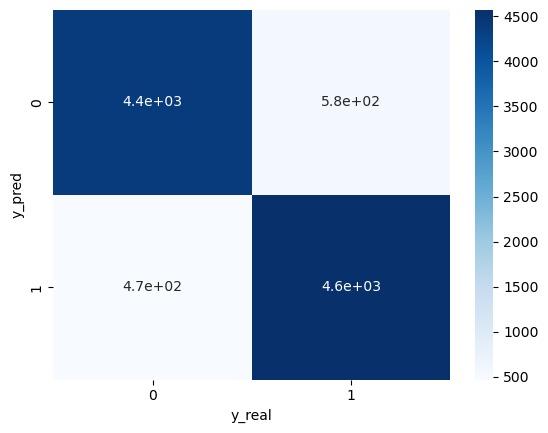

In [11]:
# Affichage via heatmap
ds_validacion=pd.DataFrame(y_predic_cat,y_test).reset_index()
ds_validacion.columns=['y_pred','y_real']

table=pd.crosstab(ds_validacion.y_pred, ds_validacion.y_real)
grf=sns.heatmap(table,annot=True, cmap = 'Blues')
plt.show()